<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Akronim; font-size:300%;'> Code Modules, Helpful Functions, Styling, and Links</h1>
#### [Github Version](https://github.com/OlgaBelitskaya/deep_learning_projects/blob/master/DL_PP4) & [Colaboratory Version](https://colab.research.google.com/drive/1r5yRD-3tQwN6lSql_VRoVuwQ8DaY5zUt)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=3d|fire-animation');
body {background-color: gainsboro;} 
a,h4 {color:#37c9e1; font-family:Roboto;} 
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#37c9e1;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}       
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import h5py,cv2,pandas as pd,numpy as np,pylab as pl
import seaborn as sn,keras as ks,tensorflow as tf
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
np.set_printoptions(precision=6)
pl.style.use('seaborn-whitegrid')
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:',tf.__version__)

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0


In [3]:
def ohe(x): 
    return OneHotEncoder(n_values='auto')\
           .fit(x.reshape(-1,1))\
           .transform(x.reshape(-1,1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,
                     random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test

<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Akronim; font-size:300%;'> Data Loading and Exploration</h1>

In [4]:
data=pd.read_csv("../input/style/style.csv")
data.head()

,brand_name,brand_label,product_name,product_label,file
0,Christian Louboutin,0,shoes,0,0_0_001.png
1,Christian Louboutin,0,shoes,0,0_0_002.png
2,Christian Louboutin,0,shoes,0,0_0_003.png
3,Christian Louboutin,0,shoes,0,0_0_004.png
4,Christian Louboutin,0,shoes,0,0_0_005.png


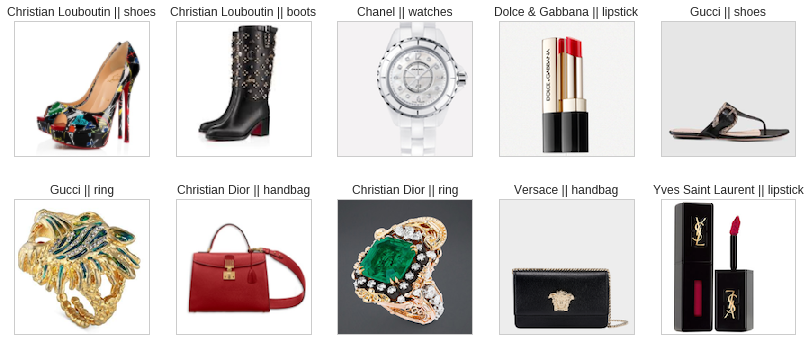

In [5]:
def display_images(img_path,ax):
    img=cv2.imread("../input/style/"+img_path)
    ax.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))   
fig=pl.figure(figsize=(14,6))
for i in range(10):
    ax=fig.add_subplot(2,5,i+1,xticks=[],yticks=[],
                       title=data['brand_name'][i*218]+' || '\
                       +data['product_name'][i*218])
    display_images(data['file'][i*218],ax)

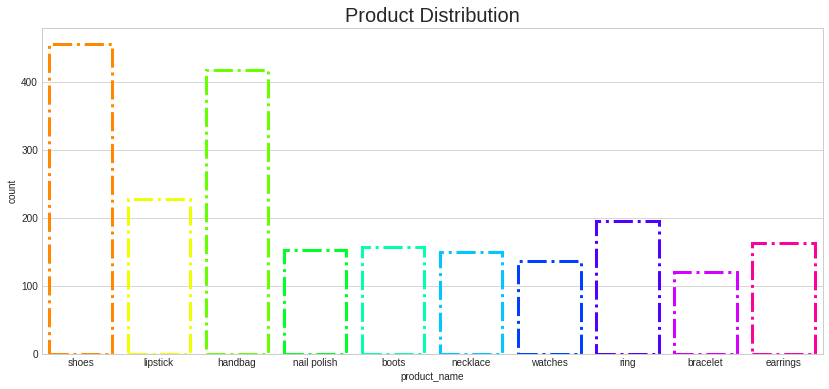

In [6]:
pl.figure(figsize=(14,6))
sn.countplot(x='product_name',data=data,
             facecolor='none',linewidth=3,linestyle='-.',
             edgecolor=sn.color_palette('hsv',10))
pl.title('Product Distribution',fontsize=20); pl.show()

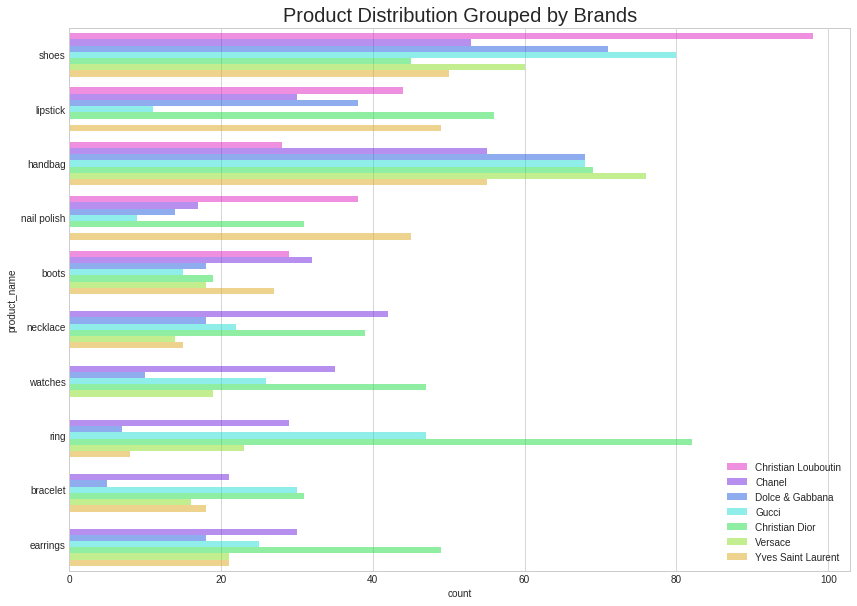

In [7]:
pl.figure(figsize=(14,10))
sn.countplot(y="product_name",hue="brand_name", 
             data=data,palette='hsv_r',alpha=.5)
ti='Product Distribution Grouped by Brands'
pl.title(ti,fontsize=20)
pl.legend(loc=4); pl.show()

In [8]:
# get unique values of brand and product names
[data['brand_name'].unique(),data['product_name'].unique()]

[array(['Christian Louboutin', 'Chanel', 'Dolce & Gabbana', 'Gucci',
        'Christian Dior', 'Versace', 'Yves Saint Laurent'], dtype=object),
 array(['shoes', 'lipstick', 'handbag', 'nail polish', 'boots', 'necklace',
        'watches', 'ring', 'bracelet', 'earrings'], dtype=object)]

In [9]:
f=h5py.File('../input/StyleColorImages.h5','r')
keys=list(f.keys())
brands=np.array(f[keys[0]])
images=np.array(f[keys[1]])
products=np.array(f[keys[2]])
[keys,
 [brands.shape,images.shape,products.shape]]

[['brands', 'images', 'products'], [(2184,), (2184, 150, 150, 3), (2184,)]]

In [10]:
# create csv files
# images_csv=images.reshape(-1,150*150*3)
# np.savetxt("style_images.csv",images_csv,fmt='%i',delimiter=",")
# read pandas dataframes from csv
# images=pd.read_csv("style_images.csv",header=None)
# images.iloc[:10,:10]

<h1 class='font-effect-3d' style='color:#37c9e1; font-family:Akronim; font-size:300%;'>Implementation of Preprocessing Functions<h1>

Product:  lipstick
Brand:  Christian Louboutin


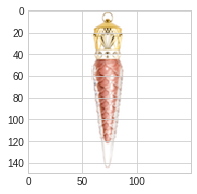

In [11]:
# normalization of image arrays
images=images.astype('float32')/255
print('Product: ',data['product_name'][100])
print('Brand: ',data['brand_name'][100])
pl.figure(figsize=(3,3)); pl.imshow(images[100])
pl.show()

Product:  lipstick
Brand:  Christian Louboutin


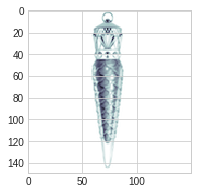

In [12]:
# grayscaling of image arrays
gray_images=np.dot(images[...,:3],[.299,.587,.114])
print('Product: ',data['product_name'][100])
print('Brand: ',data['brand_name'][100])
pl.figure(figsize=(3,3))
pl.imshow(gray_images[100],cmap=pl.cm.bone); pl.show()
gray_images=gray_images.reshape(-1,150,150,1)

In [13]:
# print brand and product unique values
[set(brands),set(products)]

[{0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]

In [14]:
# one-hot encoding
cbrands,cproducts=ohe(brands),ohe(products)
ctargets=np.concatenate((cbrands,cproducts),axis=1)
pd.DataFrame([images.shape,gray_images.shape,
              cbrands.shape,cproducts.shape,
              ctargets.shape])

,0,1,2,3
0,2184,150,150.0,3.0
1,2184,150,150.0,1.0
2,2184,7,NaN,NaN
3,2184,10,NaN,NaN
4,2184,17,NaN,NaN


In [15]:
# splitting the data
# Color Images / Brands 
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,cbrands)
# Grayscaled Images / Brands 
x_train2,x_valid2,x_test2,\
y_train2,y_valid2,y_test2=tts(gray_images,cbrands)
# Color Images / Products 
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,cproducts)
# Grayscaled Images / Products 
x_train4,x_valid4,x_test4,\
y_train4,y_valid4,y_test4=tts(gray_images,cproducts)
# Color Images / Multi-Label Targets
x_train5,x_valid5,x_test5,\
y_train5,y_valid5,y_test5=tts(images,ctargets)
# Grayscaled Images / Multi-Label Targets 
x_train6,x_valid6,x_test6,\
y_train6,y_valid6,y_test6=tts(gray_images,ctargets)
sh=[el.shape for el in \
[x_train1,y_train1,x_valid1,y_valid1,x_test1,y_test1,
 x_train3,y_train3,x_valid3,y_valid3,x_test3,y_test3,
 x_train5,y_train5,x_valid5,y_valid5,x_test5,y_test5,
 x_train2,y_train2,x_valid2,y_valid2,x_test2,y_test2,
 x_train4,y_train4,x_valid4,y_valid4,x_test4,y_test4,
 x_train6,y_train6,x_valid6,y_valid6,x_test6,y_test6]]
pd.DataFrame(sh)

,0,1,2,3
0,1747,150,150.0,3.0
1,1747,7,NaN,NaN
2,218,150,150.0,3.0
3,218,7,NaN,NaN
4,219,150,150.0,3.0
5,219,7,NaN,NaN
6,1747,150,150.0,3.0
7,1747,10,NaN,NaN
8,218,150,150.0,3.0
9,218,10,NaN,NaN


In [16]:
# creating lists of targets
y_train5_list=[y_train5[:,:7],y_train5[:,7:]]
y_test5_list=[y_test5[:,:7],y_test5[:,7:]]
y_valid5_list=[y_valid5[:,:7],y_valid5[:,7:]]
y_train6_list=[y_train6[:,:7],y_train6[:,7:]]
y_test6_list=[y_test6[:,:7],y_test6[:,7:]]
y_valid6_list=[y_valid6[:,:7],y_valid6[:,7:]]